In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
import pyperch
import numpy as np
from sklearn.datasets import make_classification
import torch
from torch import nn
from skorch import NeuralNetClassifier
from skorch import NeuralNet
from pyperch.neural.rhc_nn import RHCModule  
from pyperch.utils.decorators import add_to
import copy
import matplotlib.pyplot as plt
from torch.nn import BCEWithLogitsLoss
from skorch.callbacks import EpochScoring 
from pyperch.neural.sa_nn import SAModule  
from pyperch.neural.ga_nn import GAModule
from imblearn.under_sampling import RandomUnderSampler

In [33]:
carmax=pd.read_csv("/Users/navyabingi/Downloads/Fall 2024 Dataset.csv")
state_to_region = {
    'CT': 'Northeast', 'ME': 'Northeast', 'MA': 'Northeast', 'NH': 'Northeast',
    'RI': 'Northeast', 'VT': 'Northeast', 'NJ': 'Northeast', 'NY': 'Northeast', 'PA': 'Northeast',
    'IL': 'Midwest', 'IN': 'Midwest', 'MI': 'Midwest', 'OH': 'Midwest', 'WI': 'Midwest',
    'IA': 'Midwest', 'KS': 'Midwest', 'MN': 'Midwest', 'MO': 'Midwest', 'NE': 'Midwest', 'ND': 'Midwest', 'SD': 'Midwest',
    'AL': 'South', 'AR': 'South', 'DE': 'South', 'DC': 'South', 'FL': 'South', 'GA': 'South', 'KY': 'South',
    'LA': 'South', 'MD': 'South', 'MS': 'South', 'NC': 'South', 'OK': 'South', 'SC': 'South', 'TN': 'South', 'TX': 'South',
    'VA': 'South', 'WV': 'South',
    'AZ': 'West', 'CO': 'West', 'ID': 'West', 'MT': 'West', 'NV': 'West', 'NM': 'West', 'UT': 'West', 'WY': 'West',
    'AK': 'West', 'CA': 'West', 'HI': 'West', 'OR': 'West', 'WA': 'West'
}

carmax['region'] = carmax['state'].map(state_to_region)
regions=carmax['region']
vehicle=carmax['vehicle_class']
carmax=carmax.drop(['state','Unnamed: 0'],axis=1)
carmax=pd.get_dummies(carmax, columns=['region','vehicle_class'],dtype='int')
carmax = carmax[['campaign_a_touchpoints', 'campaign_b_touchpoints',
       'campaign_c_touchpoints', 'total_touchpoints', 'num_web_visits',
       'finance_customer', 'service_plan_customer',
       'trade_in_customer', 'region_Midwest',
       'region_Northeast', 'region_South', 'region_West',
       'vehicle_class_COMPACT', 'vehicle_class_FULL SIZE',
       'vehicle_class_LARGE SUV', 'vehicle_class_LUXURY',
       'vehicle_class_MEDIUM SUV', 'vehicle_class_MID SIZE',
       'vehicle_class_PICKUP', 'vehicle_class_SMALL SUV',
       'vehicle_class_SPORTS CAR', 'vehicle_class_VAN','purchase_flag','unaided_awareness']]
carmax['region']=regions
carmax['vehicle_class']=vehicle
carmax['trade_in_customer'] = carmax['trade_in_customer'].astype(int)
carmax['purchase_flag']=carmax['purchase_flag'].astype(int)
carmax=carmax.drop(['vehicle_class','region'],axis=1)

X = carmax.drop(['purchase_flag'], axis=1).to_numpy(dtype=np.float32)
y = carmax['purchase_flag'].to_numpy(dtype=np.float32)  


carmax['purchase_flag'].value_counts()

purchase_flag
0    69997
1    30003
Name: count, dtype: int64

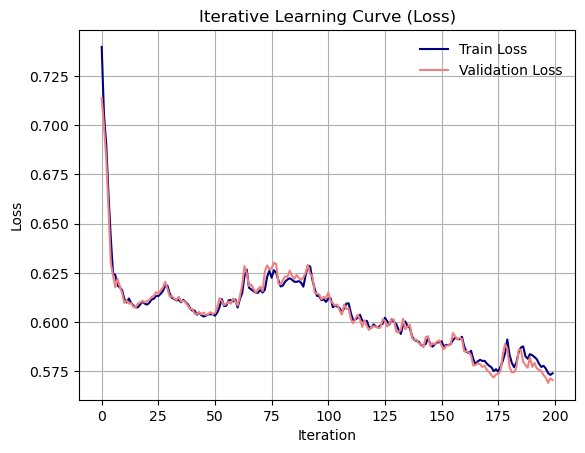

In [34]:


X = carmax.drop(['purchase_flag'], axis=1).to_numpy(dtype=np.float32)
y = carmax['purchase_flag'].to_numpy(dtype=np.float32)  


y = y.reshape(-1, 1) 
   

net = NeuralNetClassifier(
    module=RHCModule,
    module__layer_sizes=(23,12, 1), 
    module__dropout_percent=(.05),
    module__step_size=0.01,
    max_epochs=200,
    module__activation=nn.Sigmoid(),
    module__output_activation=nn.Identity(),  
    verbose=0,
    criterion=BCEWithLogitsLoss,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True)],
    iterator_train__shuffle=True,
)


net.fit(X, y)  


plt.plot(net.history[:, 'train_loss'], label='Train Loss', color='navy')
plt.plot(net.history[:, 'valid_loss'], label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss)")
plt.grid(visible=True)
plt.legend(frameon=False)
plt.show()

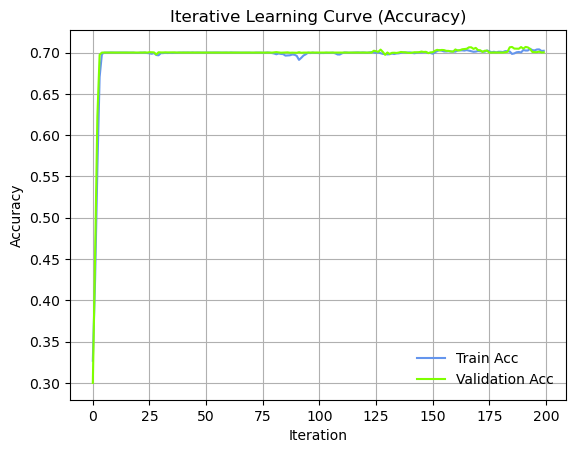

In [35]:
plt.plot(net.history[:, 'train_acc'], label='Train Acc', color='cornflowerblue')
plt.plot(net.history[:, 'valid_acc'], label='Validation Acc', color='chartreuse')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Iterative Learning Curve (Accuracy)")
plt.grid(visible=True)
plt.legend(frameon=False)

In [36]:
from sklearn.model_selection import GridSearchCV

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0, )

# module specific parameters need to begin with 'module__'
default_params = {
    'module__layer_sizes': [(23, 12, 6, 1)],
    'module__step_size': [0.01],
}

grid_search_params = {
    'max_epochs': [100, 200],
    'module__dropout_percent': [.05, .1, .2],
    **default_params,
}

#change n_jobs to run jobs in parallel, see: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html 
gs = GridSearchCV(net, grid_search_params, n_jobs=1, refit=False, cv=3, scoring='accuracy', verbose=2)

gs.fit(X, y)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END max_epochs=10, module__dropout_percent=0.05, module__layer_sizes=(23, 12, 6, 1), module__step_size=0.01; total time=   5.9s
[CV] END max_epochs=10, module__dropout_percent=0.05, module__layer_sizes=(23, 12, 6, 1), module__step_size=0.01; total time=   5.8s
[CV] END max_epochs=10, module__dropout_percent=0.05, module__layer_sizes=(23, 12, 6, 1), module__step_size=0.01; total time=   5.8s
[CV] END max_epochs=10, module__dropout_percent=0.1, module__layer_sizes=(23, 12, 6, 1), module__step_size=0.01; total time=   5.8s
[CV] END max_epochs=10, module__dropout_percent=0.1, module__layer_sizes=(23, 12, 6, 1), module__step_size=0.01; total time=   5.8s
[CV] END max_epochs=10, module__dropout_percent=0.1, module__layer_sizes=(23, 12, 6, 1), module__step_size=0.01; total time=   5.9s
[CV] END max_epochs=10, module__dropout_percent=0.2, module__layer_sizes=(23, 12, 6, 1), module__step_size=0.01; total time=   6.1s
[CV] END max_

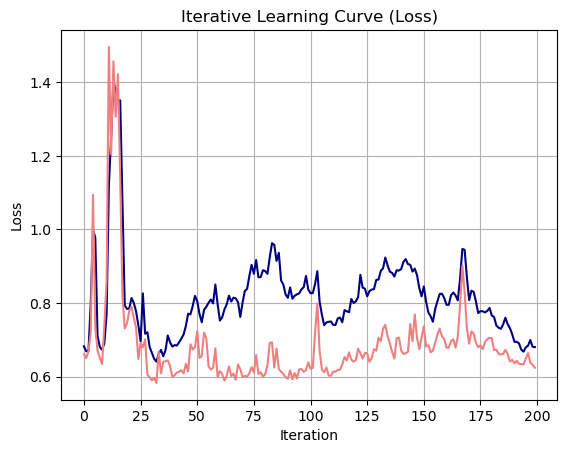

In [16]:
from skorch.callbacks import EpochScoring 
from skorch.callbacks import EarlyStopping

net2 = NeuralNetClassifier(
    module=SAModule,
    module__layer_sizes=(23, 12, 1),
    module__dropout_percent=(.2),
    module__t_min=.001,
    module__step_size=.05,
    module__t=10000,
    module__cooling=.999,
    module__activation=nn.Sigmoid(),
    module__output_activation=nn.Identity(),
    max_epochs=200,
    criterion=BCEWithLogitsLoss,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True)],
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)
net2.fit(X, y)
# plot the iterative learning curve (loss)
plt.plot(net2.history[:, 'train_loss'], label='Train Loss', color='navy')
plt.plot(net2.history[:, 'valid_loss'], label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss)")
plt.grid(visible=True)

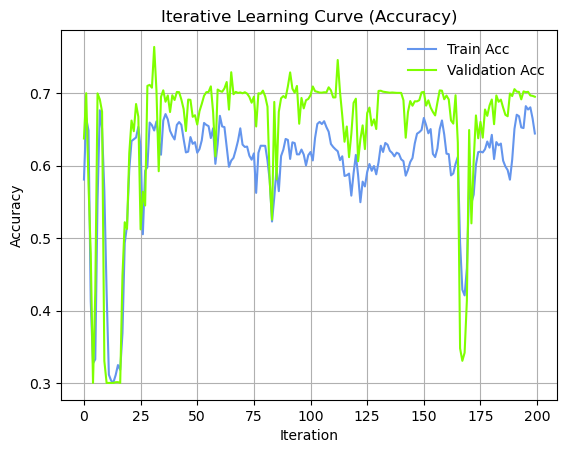

In [17]:
plt.plot(net2.history[:, 'train_acc'], label='Train Acc', color='cornflowerblue')
plt.plot(net2.history[:, 'valid_acc'], label='Validation Acc', color='chartreuse')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Iterative Learning Curve (Accuracy)")
plt.grid(visible=True)
plt.legend(frameon=False)

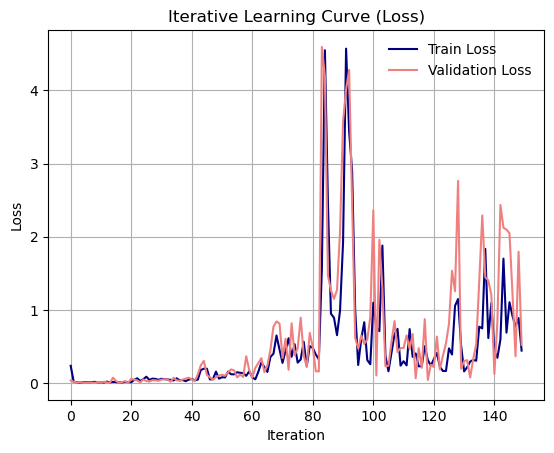

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

net3 = NeuralNetClassifier(
    module=GAModule,
    module__layer_sizes=(23, 12, 1),
    module__step_size=0.05,
    module__dropout_percent=(.001),
    module__activation=nn.ReLU(),
    module__output_activation=nn.Identity(),
    module__population_size=100,
    module__to_mate=50,
    module__to_mutate=5,
    max_epochs=150,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    criterion=nn.BCEWithLogitsLoss(),
    iterator_train__shuffle=True,
)
# fit data
net3.fit(X_train, y_train)
# plot the iterative learning curve (loss)
plt.plot(net3.history[:, 'train_loss'], label='Train Loss', color='navy')
plt.plot(net3.history[:, 'valid_loss'], label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss)")
plt.grid(visible=True)
plt.legend(frameon=False)

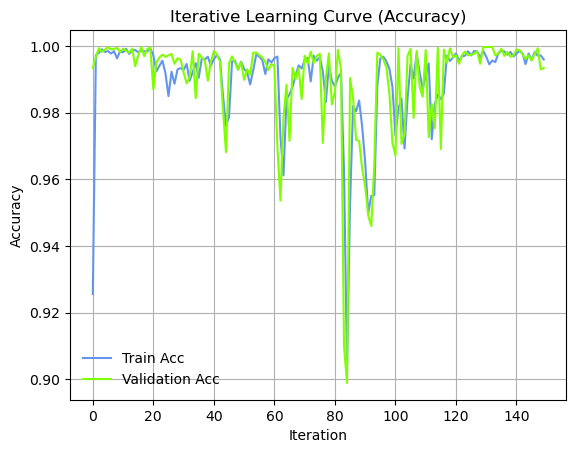

In [20]:
plt.plot(net3.history[:, 'train_acc'], label='Train Acc', color='cornflowerblue')
plt.plot(net3.history[:, 'valid_acc'], label='Validation Acc', color='chartreuse')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Iterative Learning Curve (Accuracy)")
plt.grid(visible=True)
plt.legend(frameon=False)